In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from statsmodels.imputation import mice
# Sopprime tutti i FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# ADD TIME FEATURES
def add_time_features(df, time_column):
    '''
        This function will add some time feature based on the param 'time_columns'
        
        Params:
            df-> Dataframe with the column contained in 'time_column'
            time_column -> the column that is a datetime object
        
        Returns:
            A dataframe with time features
    '''
    
    df[time_column] = pd.to_datetime(df[time_column])  # Make sure the time column is in datetime format
    df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week
    df['year'] = df[time_column].dt.year
    #df['sin_hour'] = np.sin(np.pi * df[time_column].dt.hour/24.)
    #df['sin_month'] = np.sin(np.pi * df[time_column].dt.month/12.)
    #why these feature? Who knows
    return df

In [58]:
def plot_targets(targets):
    '''
        Plot the target, by a giving date
        
        Params:
            Targets-> A dataframe with the target value
            Start_date -> the start date
            End_date -> the end date
        
        Returns:
            Sto cazzo
    '''
    plt.figure(figsize=(15, 6))
    plt.plot(targets, label='PV Measurement', color='blue')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title('PV Measurement Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
def to_datetime(df,column):
    '''
        Make the column in datetime format
    '''
    return pd.to_datetime(df[column])

In [5]:
def resampling(df,column):
    '''
        Resample df to 1 hour using mean() as aggregator and drop rows where all columns are NaN
        
        Params :
            df -> the dataframe to be resampled
            column -> the time column
    '''
    return df.set_index(keys = column).resample('1H').mean().dropna(how='all').reset_index()

In [6]:
def filter_df(df,columnlist):
    return df.drop(columns = columnlist)

In [7]:
def extract_data_calc(df):
    '''
    This function create a dataframe with 'date_forecast' as index and the column 'date_calc' resampled by '1H'.
    If there's no data in a specific bin, the resulting value for that bin would be NaN (not a number).
    Params:
        df -> dataframe with 'date_forecast' and 'date_calc' columns.
            'date_calc' is expected to contain data that the user wants to resample or analyze.
    Returns:
        A dataframe with 'date_calc' resampled.
    '''
    return df.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()



In [8]:
def is_estimated_feature(df):
    '''
        This function will create some time feature and estimated information. It's need to let the model understand is
        estimated value.
        Params:
            df -> It MUST be an estimated dataframe, that contains 'data_forecast' as datetime type
        Returns:
            A dataframe with 'time_dummy', 'time_delta' and 'is_estimated'     
    '''
    df['time_dummy'] = (df['date_forecast'] - df['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
    df['time_delta'] = (df['date_calc'] - df['date_forecast']).dt.total_seconds() / 3600
    df['is_estimated'] = 1
    return df

In [9]:
def delete_stationarity(df):
    '''
    Removes constant stretches of data within a DataFrame where the 'pv_measurement' column does not change.    
    The function identifies blocks of data where the 'pv_measurement' stays constant for more than two consecutive
    points and removes these blocks to address data stationarity.

    params:
        df -> DataFrame
              A pandas DataFrame with a 'pv_measurement' column which contains the data from which to remove stationarity.
        
    return:
        The DataFrame with constant stretches of data removed from the 'pv_measurement' column.
    '''
    
    #Calculate the difference, this need for check the constant
    df['diff'] = df['pv_measurement'].diff().fillna(0)

    # Create an indicator for constant stretches
    df['constant'] = (df['diff'] == 0).astype(int)

    # Use the indicator to mark stretches. The diff() function here identifies change-points.
    df['block'] = (df['constant'].diff() != 0).astype(int).cumsum()

    # Get the size of each constant block
    block_sizes = df.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than N consecutive time points (in this case 2)
    constant_blocks = block_sizes[block_sizes > 2].index
    
    # Remove the constant
    filtered_df = df[~df['block'].isin(constant_blocks)]
        
    return filtered_df.drop(columns=['diff', 'constant', 'block'])


In [10]:
def impute_nan(df):
    '''
        This function will impute the Nan in the give dataframe
        
        Params:
            df -> the dataframe to be imputed
        Return:
            The dataframe imputed
    '''
    
    for col in df.columns:
        df[col] = df[col].fillna(df[col].median())
    return df

In [11]:
import pandas as pd
from scipy import stats

def remove_outliers(df, column, method='IQR', **kwargs):
    '''
    Removes outliers from a specific column in a pandas DataFrame based on the selected method.
    Additionally, prints the number of outliers removed.
    
    Parameters:
    df : DataFrame
        The pandas DataFrame from which to remove outliers.
    column : str
        The name of the column from which to remove outliers.
    method : str, optional
        The method used to identify and remove outliers. Accepted values are 'IQR' for Interquartile Range or
        'Z-score'. The default is 'IQR'.
    **kwargs : additional keyword arguments
        Additional parameters required for the specified outlier removal method.
        
    Returns:
    DataFrame
        A new DataFrame with outliers removed from the specified column.
    '''

    if method == 'IQR':
        # Calculate the IQR (Interquartile Range) for the column
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Determine upper and lower bounds for outlier detection
        lower_bound = Q1 - (3 * IQR)
        upper_bound = Q3 + (3 * IQR)
        
        # Filtering before removing to determine the number of outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        non_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        
    elif method == 'Z-score':
        # Calculate Z-scores for the column
        z_scores = stats.zscore(df[column].dropna())
        
        # Define a threshold for identifying outliers
        threshold = kwargs.get('threshold', 3) # Default threshold is 3
        
        # Create masks for outliers and non-outliers
        mask = (abs(z_scores) < threshold)
        non_outliers = df[mask]
        outliers = df[~mask]
        
    else:
        raise ValueError("Method not recognized. Use 'IQR' or 'Z-score'.")
    
    # Print the number of outliers removed
    num_outliers = len(outliers)
    #if(num_outliers > 0):
       # print(f'For {column} there was outliers {num_outliers}')
    
    # Return the DataFrame without outliers
    return non_outliers

# Example usage:
# Assuming `data` is your DataFrame and you want to remove outliers from the 'price' column using IQR method:
# cleaned_data = remove_outliers(data, 'price', method='IQR')

# Or using Z-score method with a specific threshold:
# cleaned_data = remove_outliers(data, 'price', method='Z-score', threshold=2.5)


In [12]:
def one_hot_encoding(df, columns_to_encode):
    '''
        Perform one-hot encoding on the selected columns
        Params:
            df: Dataframe
            columns_to_encode: List of columns
        Return
            Dataframe with columns encoded 
    '''
    one_hot_encoded_df = pd.get_dummies(df[columns_to_encode], columns=columns_to_encode)
    return pd.concat([df, one_hot_encoded_df], axis=1)

In [13]:
def should_process_column(column_name):
    """
    Check if the column should be processed based on its name.
    
    Args:
    column_name (str): The name of the column to check.

    Returns:
    bool: True if the column should be processed, False otherwise.
    """
    excluded_substrings = ['idx', 'time', 'estimated']
    return not any(substring in column_name for substring in excluded_substrings)

In [40]:
def fix_encoding(df):
    df[['dew_or_rime:idx_-1.0', 'dew_or_rime:idx_-0.75', 'dew_or_rime:idx_-0.5', 'dew_or_rime:idx_-0.25', 'dew_or_rime:idx_0.75','is_estimated_0']] = 0
    return df

In [41]:
def preprocessing(targets, observed, estimated, test):
    '''
        This function makes all the preprocessing needed for the correct run of the model, it will perform:
            - Resampling
            - Filtering
            - Imputation
            - Outliers removal
            - Categorical Encoding
        
        Params:
            targets -> dataframe of the target parquet
            observed -> dataframe of observed train data
            estimated -> dataframe of estimated train data
            test -> dataframe of test data
        Returns:
            train_data -> dataframe of all data ready to train
            test_data -> dataframe of all data ready to test
            is_day -> dataframe of is_day categorical feature for post processing
    
    '''    
    targets['time'] = to_datetime(targets,'time')
    estimated['date_forecast'] = to_datetime(estimated,'date_forecast')
    observed['date_forecast'] = to_datetime(observed,'date_forecast')
    test['date_forecast'] = to_datetime(test,'date_forecast')

    observed_resampled = resampling(observed,'date_forecast')
    estimated_resampled = resampling(estimated,'date_forecast')
    test_resampled = resampling(test,'date_forecast')
    
    date_calc_resampled_observed = extract_data_calc(estimated)
    date_calc_resampled_test = extract_data_calc(test)
    
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_observed, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_test, left_on='date_forecast', right_index=True)
    
    is_day = test_resampled[['date_forecast', 'is_day:idx']]   
    test_resampled = filter_df(test_resampled,['is_day:idx', 'snow_density:kgm3','elevation:m'])
    observed_resampled = filter_df(observed_resampled,['is_day:idx', 'snow_density:kgm3','elevation:m']) 
    estimated_resampled = filter_df(estimated_resampled,[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    
    #This MUST be zero because is not estimated.
    observed_resampled['time_dummy'] = 0
    observed_resampled['is_estimated'] = 0
    observed_resampled['time_delta'] = 0
    
    estimated_resampled = is_estimated_feature(estimated_resampled)
    test_resampled = is_estimated_feature(test_resampled)
    
    X = pd.concat([observed_resampled,estimated_resampled],axis = 0)
    train_data = pd.merge(targets, X, how='inner', left_on='time', right_on='date_forecast')
    
    train_data = add_time_features(train_data, 'time')
    test_data = add_time_features(test_resampled, 'date_forecast')
    
    train_data = delete_stationarity(train_data)
    
    train_data = filter_df(train_data, ['time','date_calc'])
    test_data = filter_df(test_resampled, ['date_calc'])
    
    train_data = impute_nan(train_data)
    test_data = impute_nan(test_data)

    train_data = one_hot_encoding(train_data, ['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'])
    test_data = one_hot_encoding(test_data, ['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'])
    test_data = fix_encoding(test_data)
    test_data = test_data[train_data.drop(columns = 'pv_measurement').columns]
    
    cleaned_columns = {}
    columns_to_process = [column for column in train_data.columns if should_process_column(column)]
    # Loop through each column in the DataFrame
    for column in train_data.columns:
        if column in columns_to_process:
            if pd.api.types.is_numeric_dtype(train_data[column]):  # Check if the column is numeric
                # Remove outliers from the column
                cleaned_data = remove_outliers(train_data, column, method='IQR')
                # Add the cleaned column to our dictionary
                cleaned_columns[column] = cleaned_data[column]
            else:
                # For non-numeric columns, just copy the data
                cleaned_columns[column] = train_data[column]
        else:
            cleaned_columns[column] = train_data[column]

    # Create a new DataFrame using the cleaned columns
    train_cleaned_data = pd.DataFrame(cleaned_columns)
    train_cleaned_data = train_cleaned_data.set_index('date_forecast')
    test_data = test_data.set_index('date_forecast')
    return train_cleaned_data, test_data, is_day

In [62]:
from sklearn.model_selection import TimeSeriesSplit
def train_data_split(n_splits = 5):
    '''
        This function return the cross_validator split
    '''
    return TimeSeriesSplit(n_splits=n_splits)

In [63]:
import re
def regexdf(df):
    '''
        This function let lgbm work, this because it cannot accept ':'
    '''
    return df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_-]+', '', x))

In [64]:
def evaluate_model(df,model, n_splits = 5):
    '''
        This function evaluate the model by splitting the data in # fold.
        
        Params:
            df -> dataframe
            model -> A regressor model
            n_splits -> how many splits you want
    '''
    data = df
    tscv = train_data_split(n_splits)
    fold = 1
    maelist = []
    
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index] #Take the train part
        test_data = data.iloc[test_index] #Take the test part

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')
        
        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print(f'{fold} --> {mae}')
        fold +=1
        maelist.append(mae)
    print(f'Mean : {np.mean(maelist)}')
    print(f'Std : {np.std(maelist)}')

In [65]:
def objective(trial,data, tscv):
    '''
        This function is used by optuna to perform a bayesian optimization of the hyperparameter.
        PLEASE NOTE THAT IF YOU CHANGE THE MODEL YOU MUST CHANGE THE PARAM DICTIONARY.
        THIS NOT WORK PROPERLY FOR RANDOM FOREST.
        
        Params:
            trial -> optuna stuff
            data -> Dataframe
                    Your train_data
            tscv -> cross_validation split
        Returns:
            mean_mae, the mean by all the mae of each fold
    
    '''
    fold = 1
    maelist = []
    
    #CHANGE THIS PART IF YOU CHANGE THE MODEL, THIS WORK ONLY WITH LIGHTGBM
    param = {
            'metric': 'mae', 
            'random_state': 42,
            'n_estimators': trial.suggest_int('n_estimators',10,1000),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,1e-1),
            'max_depth': trial.suggest_int('max_depth', 1,50),
            'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
            'verbosity': -1
        }
    #CHANGE THIS PART IF YOU CHANGE THE MODEL, DONT MODIFY **param PART
    model = lgb.LGBMRegressor(**param)
    maelist = []
    
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')
        
        # Train the model
        model.fit(X_train, y_train,eval_set=[(X_test,y_test)])

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print(f'{fold} --> {mae}')
        fold +=1
        maelist.append(mae)    
    print(f'Mean : {np.mean(maelist)}')
    print(f'Std : {np.std(maelist)}')
    return np.mean(maelist)

In [66]:
import optuna
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)
def tune_model(df,n_trials=50, n_splits = 5):
    '''
        This function will tune your model, by using optuna.
        DONT USE THIS FOR RANDOM FOREST
        Params:
            df -> dataframe of training data
            n_trials -> how many iteration of hypertuning you want
            n_splits -> how many split you want
        Return: 
            The best hyperparameter found
    '''
    data = df
    study = optuna.create_study(direction='minimize')
    tscv = train_data_split(n_splits)
    study.optimize(lambda trial: objective(trial, data,tscv), n_trials=n_trials)
    trial = study.best_trial
    return trial.params

In [67]:
from sklearn.utils import resample
from sklearn.ensemble import BaggingRegressor  # For regression

def bagging_model(df,model,num_models = 10):
    '''
        This function will bag your model.
        Params:
            df -> train dataset
            model -> your model PLS CHANGE THE PART DOWN IF YOU DONT USE LIGHTGBM
            params -> the hyperparameter
            num_models -> how many model you want to bag
        Return:
            the bagged model
    '''
    # Create Validation - Train using estimated data DONT USE TIMESERIES SPLIT UNLESS YOU WANT TO DO #tscv * #num_models ITERATION 
    train = df[df['is_estimated'] == 0]
    test = df[df['is_estimated'] == 1]
    
    X_train = train.drop(columns = 'pv_measurement')
    y_train = train['pv_measurement']
    
    X_valid = test.drop(columns = 'pv_measurement')
    y_valid = test['pv_measurement']
    
    bagged_model = BaggingRegressor(
        base_estimator=model,  # Use the LightGBM base model
        n_estimators=num_models,  # Number of base models in the ensemble (adjust as needed)
        random_state=42  # Set the random seed for reproducibility
    )
    bagged_model.fit(X_train, y_train)  # Replace with your training data and target

    # Make predictions using the bagged model
    predictions = bagged_model.predict(X_valid)  # Replace with your validation data


    # Calculate the mean squared error of the bagged predictions
    mae = mean_absolute_error(y_valid, predictions)
    print(f"Bagged MAE: {mae}")
    return bagged_model

In [68]:
def final_model(df,model,param,X_test):
    '''
        This function will retrain on the bagged model so the model is trained on ALL TRAIN DATA.
        
        Params:
            df -> Train data
            model -> your model
            param -> your hyperparameter
            X_test -> Test Data
        Return:
            the prediction
    '''
    X_train = df.drop(columns = 'pv_measurement')
    y_train = df['pv_measurement']
    model.fit(X_train,y_train)
    return model.predict(X_test)

In [69]:
def post_process(prediction, is_day):
    '''
        This function will post_process the predicition, by multiplying the is_day on that prediction.
        I.E.
            This is for rescale the prediction that can be too high in a 0.5 day moment.
        Params:
            Prediction -> your prediction
            is_day -> the is_day dataframe
        Return:
            the clipped version of the adjusted prediction, it's clipped for any eventual negative prediction
    '''
    adjusted_predictions = prediction * is_day['is_day:idx']
    return np.clip(adjusted_predictions, 0, None)

In [70]:
def submission(predictions):
    '''
        This function will create a ready to deliver file
        
        Params: 
            predictions -> the entire prediction for all the location
        
        Returns: 
            stocazzo
        Save:
            Submission file
    
    '''
    all_predictions = np.array(predictions).flatten()
    # Save the final_predictions to CSV
    df = pd.DataFrame(all_predictions, columns=['prediction'])
    df['id'] = df.index
    df = df[['id', 'prediction']]
    df.to_csv('TestFECla3.csv', index=False)

In [144]:
def feature_engineering(df):
    '''
        This function will create new feature from the interaction of different feature of df dataframe.
        
        Params:
            df: dataframe
        Return:
            FE dataframe
    '''
    
    df['direct_diffuse_rad_interaction'] = df['direct_rad:W'] * df['diffuse_rad:W']
    df['raddir'] = (df['direct_rad:W'] ) * (df['absolute_humidity_2m:gm3'])
    df['effectivehum'] = (df['absolute_humidity_2m:gm3']) * (df['direct_rad:W'])
    df['Radiazione_solare_effettiva'] = (df['direct_rad:W'] + df['diffuse_rad:W'] ) * (df['effective_cloud_cover:p'])
    df['direct_radW_squared'] = df['direct_rad:W'] ** 2
    df['clearcloud'] =   df['clear_sky_rad:W']*df['total_cloud_cover:p']
    df['radiation_squared'] = df['clear_sky_rad:W'] ** 2
    df['effectivehum'] = (df['absolute_humidity_2m:gm3']) * (df['direct_rad:W'])

   # df = df[df.index.month.isin([4, 5, 6, 7, 8, 9])]

    return df

In [151]:
locations = ['B','C']

In [149]:
all_predictions = []

1 --> 60.02873248512057
2 --> 77.35967821081188
3 --> 54.2876062752486
4 --> 59.490544684674916


[I 2023-11-03 23:35:26,766] A new study created in memory with name: no-name-f601b117-1df5-4a28-a058-29d8b0362c67


5 --> 53.91127465952274
Mean : 61.01556726307574
Std : 8.557639065374799
__________
1 --> 85.89601952466532
2 --> 94.2468433606805
3 --> 86.89956979580636
4 --> 86.55084601040711


[I 2023-11-03 23:35:36,729] Trial 0 finished with value: 87.54645218187649 and parameters: {'n_estimators': 729, 'reg_alpha': 0.015194914410699234, 'reg_lambda': 0.013810558654892037, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.0018300745974126269, 'max_depth': 48, 'num_leaves': 749, 'min_child_samples': 112, 'min_data_per_groups': 34}. Best is trial 0 with value: 87.54645218187649.


5 --> 84.13898221782311
Mean : 87.54645218187649
Std : 3.4825194882724015
1 --> 57.04748693828791
2 --> 74.48466515343328
3 --> 51.11716261544208
4 --> 59.72237065853287


[I 2023-11-03 23:35:41,984] Trial 1 finished with value: 59.18445280050364 and parameters: {'n_estimators': 752, 'reg_alpha': 0.8721483486855206, 'reg_lambda': 0.04146537327949163, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.02175302609890348, 'max_depth': 41, 'num_leaves': 200, 'min_child_samples': 227, 'min_data_per_groups': 21}. Best is trial 1 with value: 59.18445280050364.


5 --> 53.55057863682205
Mean : 59.18445280050364
Std : 8.194805498426335
1 --> 208.84234523551908
2 --> 212.1437129040628
3 --> 208.7369034651023
4 --> 202.50055171276077


[I 2023-11-03 23:35:43,752] Trial 2 finished with value: 204.7478716879714 and parameters: {'n_estimators': 225, 'reg_alpha': 0.9202664864745359, 'reg_lambda': 0.017076356575051355, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.00011977186804336893, 'max_depth': 8, 'num_leaves': 26, 'min_child_samples': 200, 'min_data_per_groups': 90}. Best is trial 1 with value: 59.18445280050364.


5 --> 191.5158451224121
Mean : 204.7478716879714
Std : 7.314540717595494
1 --> 163.1051336138892
2 --> 165.63257372051788
3 --> 161.50051154040412
4 --> 157.89505969286753


[I 2023-11-03 23:35:44,455] Trial 3 finished with value: 160.00718716034882 and parameters: {'n_estimators': 85, 'reg_alpha': 0.28310761595527856, 'reg_lambda': 0.012281231062844889, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.003961068551937152, 'max_depth': 46, 'num_leaves': 110, 'min_child_samples': 286, 'min_data_per_groups': 13}. Best is trial 1 with value: 59.18445280050364.


5 --> 151.90265723406534
Mean : 160.00718716034882
Std : 4.766901543965744
1 --> 198.98467748972715
2 --> 201.70858750752265
3 --> 198.56185730766103
4 --> 193.32366267824887


[I 2023-11-03 23:35:46,369] Trial 4 finished with value: 195.01798755802082 and parameters: {'n_estimators': 758, 'reg_alpha': 0.004499006654686778, 'reg_lambda': 0.06414883938316264, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.00011885681063948608, 'max_depth': 2, 'num_leaves': 296, 'min_child_samples': 283, 'min_data_per_groups': 4}. Best is trial 1 with value: 59.18445280050364.


5 --> 182.51115280694435
Mean : 195.01798755802082
Std : 6.816882304836096
1 --> 179.90545521507025
2 --> 182.41982766828986
3 --> 180.3678967397828
4 --> 175.02399945107456


[I 2023-11-03 23:35:52,184] Trial 5 finished with value: 177.0408428224263 and parameters: {'n_estimators': 391, 'reg_alpha': 0.5135088375397622, 'reg_lambda': 0.02493305264397738, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.0005066912425829513, 'max_depth': 17, 'num_leaves': 673, 'min_child_samples': 80, 'min_data_per_groups': 6}. Best is trial 1 with value: 59.18445280050364.


5 --> 167.487035037914
Mean : 177.0408428224263
Std : 5.358202502128663
1 --> 190.92825322676734
2 --> 193.60227140091249
3 --> 191.2562431459657
4 --> 185.48040757589334


[I 2023-11-03 23:36:04,777] Trial 6 finished with value: 187.61265049958445 and parameters: {'n_estimators': 890, 'reg_alpha': 0.026129957944939042, 'reg_lambda': 0.5531476740010292, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.00014474416029843483, 'max_depth': 23, 'num_leaves': 372, 'min_child_samples': 77, 'min_data_per_groups': 1}. Best is trial 1 with value: 59.18445280050364.


5 --> 176.79607714838338
Mean : 187.61265049958445
Std : 6.0280886905624715
1 --> 210.9170946890783
2 --> 214.16235661841608
3 --> 210.70921487486785


[I 2023-11-03 23:36:05,183] Trial 7 finished with value: 206.6879007440469 and parameters: {'n_estimators': 41, 'reg_alpha': 0.0010423559382129759, 'reg_lambda': 4.238965645593345, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.0003809642860883906, 'max_depth': 5, 'num_leaves': 990, 'min_child_samples': 14, 'min_data_per_groups': 57}. Best is trial 1 with value: 59.18445280050364.


4 --> 204.4490326450052
5 --> 193.2018048928671
Mean : 206.6879007440469
Std : 7.440589372535461
1 --> 200.57855847666517
2 --> 203.53695662600416
3 --> 200.23241336626262
4 --> 194.2537589407939


[I 2023-11-03 23:36:13,902] Trial 8 finished with value: 196.63119756815874 and parameters: {'n_estimators': 672, 'reg_alpha': 0.35700138707528806, 'reg_lambda': 6.250267999351691, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.00011201210628675762, 'max_depth': 17, 'num_leaves': 599, 'min_child_samples': 53, 'min_data_per_groups': 38}. Best is trial 1 with value: 59.18445280050364.


5 --> 184.55430043106787
Mean : 196.63119756815874
Std : 6.748978891925677
1 --> 58.03538794495076
2 --> 78.66490752324206
3 --> 52.20373567058924
4 --> 59.834292358104015


[I 2023-11-03 23:36:20,980] Trial 9 finished with value: 60.968964962345225 and parameters: {'n_estimators': 243, 'reg_alpha': 0.003721702864850646, 'reg_lambda': 0.015472543775307025, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.09556585437732892, 'max_depth': 38, 'num_leaves': 845, 'min_child_samples': 48, 'min_data_per_groups': 6}. Best is trial 1 with value: 59.18445280050364.


5 --> 56.106501314840095
Mean : 60.968964962345225
Std : 9.20339650797168
1 --> 60.981296287708936
2 --> 76.42492269256377
3 --> 51.76132606072491
4 --> 59.251705523573854


[I 2023-11-03 23:36:29,289] Trial 10 finished with value: 60.664663109262435 and parameters: {'n_estimators': 981, 'reg_alpha': 8.473378544797654, 'reg_lambda': 0.0012632319672873516, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.03155084895505526, 'max_depth': 34, 'num_leaves': 216, 'min_child_samples': 179, 'min_data_per_groups': 72}. Best is trial 1 with value: 59.18445280050364.


5 --> 54.90406498174071
Mean : 60.664663109262435
Std : 8.519816773010524
1 --> 60.908362053334685
2 --> 76.04518524428232
3 --> 51.59762556232361
4 --> 60.431431643890825


[I 2023-11-03 23:36:37,361] Trial 11 finished with value: 60.970688566773084 and parameters: {'n_estimators': 999, 'reg_alpha': 8.469398177879471, 'reg_lambda': 0.0013771992503597333, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.04168172197727145, 'max_depth': 36, 'num_leaves': 222, 'min_child_samples': 189, 'min_data_per_groups': 71}. Best is trial 1 with value: 59.18445280050364.


5 --> 55.87083833003399
Mean : 60.970688566773084
Std : 8.26314607429807
1 --> 55.566690568602475
2 --> 74.54271827562944
3 --> 50.34683584073849
4 --> 58.28790559900595


[I 2023-11-03 23:36:41,289] Trial 12 finished with value: 58.402317565279375 and parameters: {'n_estimators': 536, 'reg_alpha': 6.031356650991469, 'reg_lambda': 0.0018625269105163721, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.019077915335731922, 'max_depth': 33, 'num_leaves': 424, 'min_child_samples': 215, 'min_data_per_groups': 81}. Best is trial 12 with value: 58.402317565279375.


5 --> 53.26743754242053
Mean : 58.402317565279375
Std : 8.48320911349644
1 --> 56.40117938354061
2 --> 74.7207420397251
3 --> 50.64870141447419
4 --> 58.415278260933945


[I 2023-11-03 23:36:44,202] Trial 13 finished with value: 58.62694680412352 and parameters: {'n_estimators': 552, 'reg_alpha': 2.1374975439941064, 'reg_lambda': 0.2513707954807767, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.01189946026014902, 'max_depth': 30, 'num_leaves': 481, 'min_child_samples': 245, 'min_data_per_groups': 98}. Best is trial 12 with value: 58.402317565279375.


5 --> 52.94883292194377
Mean : 58.62694680412352
Std : 8.48413184745074
1 --> 57.052091254694815
2 --> 74.92870106257709
3 --> 51.55010837787142
4 --> 58.14510755545257


[I 2023-11-03 23:36:46,636] Trial 14 finished with value: 58.93709910481509 and parameters: {'n_estimators': 507, 'reg_alpha': 2.9329852902927285, 'reg_lambda': 0.21872996131704728, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.0096308846197362, 'max_depth': 29, 'num_leaves': 495, 'min_child_samples': 243, 'min_data_per_groups': 95}. Best is trial 12 with value: 58.402317565279375.


5 --> 53.0094872734796
Mean : 58.93709910481509
Std : 8.362009954642657
1 --> 55.09156137941138
2 --> 74.88884534351168
3 --> 50.70516859170699
4 --> 57.19166970788943


[I 2023-11-03 23:36:51,270] Trial 15 finished with value: 58.118918369843506 and parameters: {'n_estimators': 538, 'reg_alpha': 2.4149551152310975, 'reg_lambda': 0.0044050659923897, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.009447774116506838, 'max_depth': 27, 'num_leaves': 461, 'min_child_samples': 157, 'min_data_per_groups': 81}. Best is trial 15 with value: 58.118918369843506.


5 --> 52.717346826698
Mean : 58.118918369843506
Std : 8.664823045386624
1 --> 67.05008596333741
2 --> 80.06273266834916
3 --> 66.39109096795615
4 --> 68.38665986163662


[I 2023-11-03 23:36:55,347] Trial 16 finished with value: 69.42621910326935 and parameters: {'n_estimators': 370, 'reg_alpha': 0.12473152190974329, 'reg_lambda': 0.0033638785679931055, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.005602767265691612, 'max_depth': 23, 'num_leaves': 400, 'min_child_samples': 119, 'min_data_per_groups': 78}. Best is trial 15 with value: 58.118918369843506.


5 --> 65.2405260550673
Mean : 69.42621910326935
Std : 5.414686362610678
1 --> 91.64616337162172
2 --> 98.82077732422816
3 --> 92.19384648139248
4 --> 90.9334497907907


[I 2023-11-03 23:37:01,542] Trial 17 finished with value: 92.49266020498537 and parameters: {'n_estimators': 594, 'reg_alpha': 2.6925024958032595, 'reg_lambda': 0.004511007777564842, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.002051912851085928, 'max_depth': 16, 'num_leaves': 596, 'min_child_samples': 147, 'min_data_per_groups': 59}. Best is trial 15 with value: 58.118918369843506.


5 --> 88.8690640568938
Mean : 92.49266020498537
Std : 3.358943255410931
1 --> 55.2361113551146
2 --> 74.62297423663725
3 --> 50.94870093058118
4 --> 56.948921824582605


[I 2023-11-03 23:37:05,154] Trial 18 finished with value: 58.05667703007722 and parameters: {'n_estimators': 409, 'reg_alpha': 5.417378567706603, 'reg_lambda': 0.004360392551805239, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.01260887379569523, 'max_depth': 27, 'num_leaves': 427, 'min_child_samples': 157, 'min_data_per_groups': 80}. Best is trial 18 with value: 58.05667703007722.


5 --> 52.52667680347043
Mean : 58.05667703007722
Std : 8.540833006158525
1 --> 58.0679154517959
2 --> 75.86719782830974
3 --> 55.63169176763431
4 --> 59.85798946961373


[I 2023-11-03 23:37:08,754] Trial 19 finished with value: 61.048883945598924 and parameters: {'n_estimators': 416, 'reg_alpha': 1.5589817084248871, 'reg_lambda': 0.004049656039334597, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.007522638823278548, 'max_depth': 12, 'num_leaves': 584, 'min_child_samples': 155, 'min_data_per_groups': 47}. Best is trial 18 with value: 58.05667703007722.


5 --> 55.81962521064094
Mean : 61.048883945598924
Std : 7.570706006055893
1 --> 119.6184338429908
2 --> 123.81316799237108
3 --> 120.51563294451273
4 --> 117.30853474813841


[I 2023-11-03 23:37:10,751] Trial 20 finished with value: 119.25227638278395 and parameters: {'n_estimators': 234, 'reg_alpha': 3.389099840316092, 'reg_lambda': 0.007043145463749691, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.003191870466094739, 'max_depth': 26, 'num_leaves': 316, 'min_child_samples': 134, 'min_data_per_groups': 65}. Best is trial 18 with value: 58.05667703007722.


5 --> 115.00561238590674
Mean : 119.25227638278395
Std : 2.978058428129245
1 --> 55.246209155746364
2 --> 74.21536976658629
3 --> 50.22297211650462
4 --> 57.16005109885511


[I 2023-11-03 23:37:13,637] Trial 21 finished with value: 57.91770454667305 and parameters: {'n_estimators': 427, 'reg_alpha': 9.661610059726769, 'reg_lambda': 0.002246888642378946, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.01624027907121199, 'max_depth': 31, 'num_leaves': 434, 'min_child_samples': 211, 'min_data_per_groups': 83}. Best is trial 21 with value: 57.91770454667305.


5 --> 52.74392059567287
Mean : 57.91770454667305
Std : 8.477048608267095
1 --> 55.04380053157454
2 --> 75.02065036440206
3 --> 51.225189587359125
4 --> 57.56987757790002


[I 2023-11-03 23:37:16,576] Trial 22 finished with value: 58.38454766247836 and parameters: {'n_estimators': 321, 'reg_alpha': 9.520423598853922, 'reg_lambda': 0.0028199192983719957, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.013704134675535487, 'max_depth': 26, 'num_leaves': 498, 'min_child_samples': 157, 'min_data_per_groups': 87}. Best is trial 21 with value: 57.91770454667305.


5 --> 53.06322025115605
Mean : 58.38454766247836
Std : 8.580875541744762
1 --> 56.2141278106505
2 --> 75.33805775170862
3 --> 52.05050557425823
4 --> 57.63011885060936


[I 2023-11-03 23:37:21,699] Trial 23 finished with value: 58.92941880522808 and parameters: {'n_estimators': 641, 'reg_alpha': 4.72157100164819, 'reg_lambda': 0.001011241767655592, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.006363609467561877, 'max_depth': 41, 'num_leaves': 348, 'min_child_samples': 181, 'min_data_per_groups': 83}. Best is trial 21 with value: 57.91770454667305.


5 --> 53.41428403891365
Mean : 58.92941880522808
Std : 8.438490106210784
1 --> 54.956116026751815
2 --> 75.13664987654197
3 --> 50.110665691326794
4 --> 57.13112555739409


[I 2023-11-03 23:37:29,034] Trial 24 finished with value: 58.1913251559893 and parameters: {'n_estimators': 469, 'reg_alpha': 1.4296579959433284, 'reg_lambda': 0.007499693422612697, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.01629606346059605, 'max_depth': 21, 'num_leaves': 716, 'min_child_samples': 98, 'min_data_per_groups': 74}. Best is trial 21 with value: 57.91770454667305.


5 --> 53.62206862793182
Mean : 58.1913251559893
Std : 8.773936331963801
1 --> 63.79129067889992
2 --> 78.1454365463941
3 --> 58.12001203305665
4 --> 62.149503469921314


[I 2023-11-03 23:37:31,765] Trial 25 finished with value: 64.12699050190028 and parameters: {'n_estimators': 306, 'reg_alpha': 4.360034656174261, 'reg_lambda': 0.002463073779826335, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.009413230286150077, 'max_depth': 30, 'num_leaves': 424, 'min_child_samples': 261, 'min_data_per_groups': 66}. Best is trial 21 with value: 57.91770454667305.


5 --> 58.42870978122946
Mean : 64.12699050190028
Std : 7.33613211892904
1 --> 55.02867596754978
2 --> 74.94067754120681
3 --> 52.00830554606095
4 --> 57.35950212918616


[I 2023-11-03 23:37:33,860] Trial 26 finished with value: 58.553185169575706 and parameters: {'n_estimators': 144, 'reg_alpha': 9.738301295731977, 'reg_lambda': 0.005660909780360347, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.029664721186125457, 'max_depth': 21, 'num_leaves': 547, 'min_child_samples': 166, 'min_data_per_groups': 92}. Best is trial 21 with value: 57.91770454667305.


5 --> 53.428764663874844
Mean : 58.553185169575706
Std : 8.384415129892993
1 --> 63.68009707460596
2 --> 78.01555421889066
3 --> 59.765286504713345
4 --> 63.28027073038057


[I 2023-11-03 23:37:38,337] Trial 27 finished with value: 64.90249178315331 and parameters: {'n_estimators': 485, 'reg_alpha': 3.4979249169636724, 'reg_lambda': 0.002380052661598963, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.005393601920824873, 'max_depth': 28, 'num_leaves': 268, 'min_child_samples': 205, 'min_data_per_groups': 54}. Best is trial 21 with value: 57.91770454667305.


5 --> 59.771250387176046
Mean : 64.90249178315331
Std : 6.7645956678534995
1 --> 59.847523728938945
2 --> 76.51420939546536
3 --> 51.21684967422118
4 --> 58.31856362293819


[I 2023-11-03 23:37:43,237] Trial 28 finished with value: 60.122765955147905 and parameters: {'n_estimators': 407, 'reg_alpha': 1.5491512774943037, 'reg_lambda': 0.008095392476890615, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.050843923641172774, 'max_depth': 32, 'num_leaves': 139, 'min_child_samples': 139, 'min_data_per_groups': 100}. Best is trial 21 with value: 57.91770454667305.


5 --> 54.71668335417582
Mean : 60.122765955147905
Std : 8.724120543495193
1 --> 55.37440910994544
2 --> 75.80036262333495
3 --> 50.79523581524959
4 --> 57.58228165608732


[I 2023-11-03 23:37:56,792] Trial 29 finished with value: 58.71648180397624 and parameters: {'n_estimators': 827, 'reg_alpha': 4.543208855676713, 'reg_lambda': 0.0255616123072828, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.013384430247487037, 'max_depth': 39, 'num_leaves': 715, 'min_child_samples': 107, 'min_data_per_groups': 44}. Best is trial 21 with value: 57.91770454667305.


5 --> 54.03011981526389
Mean : 58.71648180397624
Std : 8.820691247525627
1 --> 83.29986035110682
2 --> 92.13528453869515
3 --> 83.96955798874829
4 --> 83.79051474238159


[I 2023-11-03 23:38:06,435] Trial 30 finished with value: 84.95932784151483 and parameters: {'n_estimators': 605, 'reg_alpha': 0.8727993153621427, 'reg_lambda': 0.0011155375847097342, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.0023279036725167477, 'max_depth': 44, 'num_leaves': 830, 'min_child_samples': 125, 'min_data_per_groups': 84}. Best is trial 21 with value: 57.91770454667305.


5 --> 81.60142158664227
Mean : 84.95932784151483
Std : 3.684277126118264
1 --> 54.71416805512299
2 --> 75.14054867695123
3 --> 50.07982787125664
4 --> 57.08677818690928


[I 2023-11-03 23:38:14,398] Trial 31 finished with value: 58.20652484665281 and parameters: {'n_estimators': 467, 'reg_alpha': 1.6148477009656317, 'reg_lambda': 0.007993410162723667, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.0177514443344081, 'max_depth': 20, 'num_leaves': 817, 'min_child_samples': 92, 'min_data_per_groups': 75}. Best is trial 21 with value: 57.91770454667305.


5 --> 54.01130144302391
Mean : 58.20652484665281
Std : 8.761902245091928
1 --> 54.59939658544388
2 --> 74.80087423591809
3 --> 49.68865402867837
4 --> 57.17300953551643


[I 2023-11-03 23:38:20,867] Trial 32 finished with value: 57.97054050944989 and parameters: {'n_estimators': 453, 'reg_alpha': 1.4848551290031387, 'reg_lambda': 0.004214021907149654, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.018134630998588527, 'max_depth': 24, 'num_leaves': 661, 'min_child_samples': 102, 'min_data_per_groups': 62}. Best is trial 21 with value: 57.91770454667305.


5 --> 53.590768161692715
Mean : 57.97054050944989
Std : 8.752517921759466
1 --> 55.72033332405505
2 --> 74.16609544752431
3 --> 50.16436411335887
4 --> 57.86345069818502


[I 2023-11-03 23:38:23,431] Trial 33 finished with value: 58.127008078371794 and parameters: {'n_estimators': 313, 'reg_alpha': 5.0483788342429605, 'reg_lambda': 0.003765963684169005, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.025760154465154117, 'max_depth': 24, 'num_leaves': 625, 'min_child_samples': 225, 'min_data_per_groups': 63}. Best is trial 21 with value: 57.91770454667305.


5 --> 52.72079680873571
Mean : 58.127008078371794
Std : 8.434982972200018
1 --> 55.660489968257295
2 --> 74.73448743284634
3 --> 50.93174489221106
4 --> 58.23350066097339


[I 2023-11-03 23:38:31,728] Trial 34 finished with value: 58.32273126599896 and parameters: {'n_estimators': 699, 'reg_alpha': 0.9892371394311449, 'reg_lambda': 0.0019852804941096107, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.008478222322699132, 'max_depth': 13, 'num_leaves': 465, 'min_child_samples': 192, 'min_data_per_groups': 89}. Best is trial 21 with value: 57.91770454667305.


5 --> 52.05343337570674
Mean : 58.32273126599896
Std : 8.60664867324173
1 --> 56.25041753206076
2 --> 75.42196331403912
3 --> 50.794570146505194
4 --> 58.06826023420693


[I 2023-11-03 23:38:38,572] Trial 35 finished with value: 58.775370751438004 and parameters: {'n_estimators': 567, 'reg_alpha': 0.5540212064499875, 'reg_lambda': 0.012029878158865814, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.02045962382719584, 'max_depth': 26, 'num_leaves': 535, 'min_child_samples': 171, 'min_data_per_groups': 33}. Best is trial 21 with value: 57.91770454667305.


5 --> 53.34164253037803
Mean : 58.775370751438004
Std : 8.685655054915646
1 --> 54.35362982050797
2 --> 74.61392419554222
3 --> 50.4356539032859
4 --> 57.05547305769553


[I 2023-11-03 23:38:44,472] Trial 36 finished with value: 57.82033727955019 and parameters: {'n_estimators': 438, 'reg_alpha': 1.9835010380969074, 'reg_lambda': 0.03244262418358882, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.01125176164613616, 'max_depth': 35, 'num_leaves': 648, 'min_child_samples': 126, 'min_data_per_groups': 69}. Best is trial 36 with value: 57.82033727955019.


5 --> 52.6430054207193
Mean : 57.82033727955019
Std : 8.67140073037304
1 --> 78.32897577130646
2 --> 88.53830711227737
3 --> 79.91983206240157
4 --> 80.06651506176965


[I 2023-11-03 23:38:49,388] Trial 37 finished with value: 80.95127726380227 and parameters: {'n_estimators': 346, 'reg_alpha': 0.20180139250579165, 'reg_lambda': 0.04137945160857078, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.004356418110524909, 'max_depth': 35, 'num_leaves': 674, 'min_child_samples': 65, 'min_data_per_groups': 68}. Best is trial 36 with value: 57.82033727955019.


5 --> 77.90275631125637
Mean : 80.95127726380227
Std : 3.887921048451146
1 --> 62.400285706220025
2 --> 78.30303245994406
3 --> 63.821696653519396
4 --> 66.86391653154195


[I 2023-11-03 23:38:55,399] Trial 38 finished with value: 67.06655966231423 and parameters: {'n_estimators': 162, 'reg_alpha': 0.5479655936813268, 'reg_lambda': 0.017721279649043433, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.013212642869920688, 'max_depth': 46, 'num_leaves': 907, 'min_child_samples': 34, 'min_data_per_groups': 60}. Best is trial 36 with value: 57.82033727955019.


5 --> 63.94386696034579
Mean : 67.06655966231423
Std : 5.802651867214154
1 --> 68.44255100722238
2 --> 82.06137902510224
3 --> 68.5040821616789
4 --> 71.08073765396136


[I 2023-11-03 23:39:06,364] Trial 39 finished with value: 71.52619576585366 and parameters: {'n_estimators': 456, 'reg_alpha': 5.76737011449132, 'reg_lambda': 0.011649166957175187, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.004217945954434193, 'max_depth': 49, 'num_leaves': 768, 'min_child_samples': 83, 'min_data_per_groups': 20}. Best is trial 36 with value: 57.82033727955019.


5 --> 67.5422289813034
Mean : 71.52619576585366
Std : 5.398194998511528
1 --> 55.95289885787581
2 --> 75.71817348659117
3 --> 50.52811651582549
4 --> 58.187826301628434


[I 2023-11-03 23:39:13,472] Trial 40 finished with value: 58.85431389283434 and parameters: {'n_estimators': 424, 'reg_alpha': 1.153123728288568, 'reg_lambda': 0.03279542762151941, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.025216126190315102, 'max_depth': 32, 'num_leaves': 652, 'min_child_samples': 124, 'min_data_per_groups': 78}. Best is trial 36 with value: 57.82033727955019.


5 --> 53.88455430225084
Mean : 58.85431389283434
Std : 8.80086641713604
1 --> 53.531469650991134
2 --> 74.45484137575525
3 --> 50.351668790380025
4 --> 57.085774241193555


[I 2023-11-03 23:39:21,860] Trial 41 finished with value: 57.62493198728326 and parameters: {'n_estimators': 529, 'reg_alpha': 2.3639688241709598, 'reg_lambda': 0.00448381361714765, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.008956356626491089, 'max_depth': 28, 'num_leaves': 534, 'min_child_samples': 106, 'min_data_per_groups': 80}. Best is trial 41 with value: 57.62493198728326.


5 --> 52.70090587809634
Mean : 57.62493198728326
Std : 8.688375747553394
1 --> 73.28560531081091
2 --> 84.33601973696456
3 --> 73.5310206840306
4 --> 74.5873362063269


[I 2023-11-03 23:39:26,754] Trial 42 finished with value: 75.53549643369834 and parameters: {'n_estimators': 262, 'reg_alpha': 1.8429452311926213, 'reg_lambda': 0.0018033569587580646, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.00660738613553064, 'max_depth': 38, 'num_leaves': 543, 'min_child_samples': 102, 'min_data_per_groups': 69}. Best is trial 41 with value: 57.62493198728326.


5 --> 71.93750023035872
Mean : 75.53549643369834
Std : 4.480484973821492
1 --> 54.03377814224862
2 --> 74.9556399722078
3 --> 50.769798155776876
4 --> 57.32650090175206


[I 2023-11-03 23:39:33,383] Trial 43 finished with value: 58.154216135042624 and parameters: {'n_estimators': 370, 'reg_alpha': 2.4935137449631886, 'reg_lambda': 0.005741997269722839, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.011696626375439945, 'max_depth': 31, 'num_leaves': 561, 'min_child_samples': 112, 'min_data_per_groups': 52}. Best is trial 41 with value: 57.62493198728326.


5 --> 53.68536350322775
Mean : 58.154216135042624
Std : 8.653915153886429
1 --> 56.0021807377028
2 --> 74.67154109324157
3 --> 50.185973970143515
4 --> 57.84663400591597


[I 2023-11-03 23:39:41,060] Trial 44 finished with value: 58.42678002004122 and parameters: {'n_estimators': 629, 'reg_alpha': 0.6922288768908085, 'reg_lambda': 0.06515850898181125, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.01672857602806794, 'max_depth': 36, 'num_leaves': 357, 'min_child_samples': 136, 'min_data_per_groups': 86}. Best is trial 41 with value: 57.62493198728326.


5 --> 53.42757029320226
Mean : 58.42678002004122
Std : 8.520686540977069
1 --> 57.30440226464566
2 --> 75.72890899050934
3 --> 51.529510929606964
4 --> 60.450965254899565


[I 2023-11-03 23:39:45,701] Trial 45 finished with value: 59.81364312819736 and parameters: {'n_estimators': 429, 'reg_alpha': 0.3347781813249374, 'reg_lambda': 0.022043170091192058, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.0205993940110808, 'max_depth': 24, 'num_leaves': 768, 'min_child_samples': 300, 'min_data_per_groups': 75}. Best is trial 41 with value: 57.62493198728326.


5 --> 54.05442820132525
Mean : 59.81364312819736
Std : 8.506392414298833
1 --> 58.559979373526296
2 --> 76.33274730594471
3 --> 50.77628412477767
4 --> 58.165568487555895


[I 2023-11-03 23:39:52,251] Trial 46 finished with value: 59.749545709757264 and parameters: {'n_estimators': 513, 'reg_alpha': 6.594145263660922, 'reg_lambda': 0.012533424347760514, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.038138566691057765, 'max_depth': 18, 'num_leaves': 653, 'min_child_samples': 88, 'min_data_per_groups': 93}. Best is trial 41 with value: 57.62493198728326.


5 --> 54.91314925698174
Mean : 59.749545709757264
Std : 8.750277495136148
1 --> 55.52458583918083
2 --> 76.3460958582591
3 --> 50.91739162177345
4 --> 57.559176057243874


[I 2023-11-03 23:40:16,248] Trial 47 finished with value: 58.909845583352286 and parameters: {'n_estimators': 735, 'reg_alpha': 3.342985309379711, 'reg_lambda': 0.002843361398064511, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.009985568954851722, 'max_depth': 28, 'num_leaves': 427, 'min_child_samples': 57, 'min_data_per_groups': 62}. Best is trial 41 with value: 57.62493198728326.


5 --> 54.2019785403042
Mean : 58.909845583352286
Std : 8.981652941150971
1 --> 56.36786438508091
2 --> 76.20235955648647
3 --> 52.29391507520132
4 --> 58.22782863680474


[I 2023-11-03 23:40:25,782] Trial 48 finished with value: 59.59251049784109 and parameters: {'n_estimators': 273, 'reg_alpha': 6.751429152106341, 'reg_lambda': 0.0016024393544693807, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.05554034466492224, 'max_depth': 34, 'num_leaves': 271, 'min_child_samples': 32, 'min_data_per_groups': 79}. Best is trial 41 with value: 57.62493198728326.


5 --> 54.87058483563205
Mean : 59.59251049784109
Std : 8.528937354538025
1 --> 55.55854026152474
2 --> 75.12344209547919
3 --> 50.41486740842185
4 --> 57.49468915731587


[I 2023-11-03 23:40:33,198] Trial 49 finished with value: 58.48146911136818 and parameters: {'n_estimators': 375, 'reg_alpha': 2.1301242105023404, 'reg_lambda': 0.0051196857523304285, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.02374747849623242, 'max_depth': 40, 'num_leaves': 709, 'min_child_samples': 68, 'min_data_per_groups': 70}. Best is trial 41 with value: 57.62493198728326.


5 --> 53.815806634099246
Mean : 58.48146911136818
Std : 8.64072892675866
__________
__________
__________


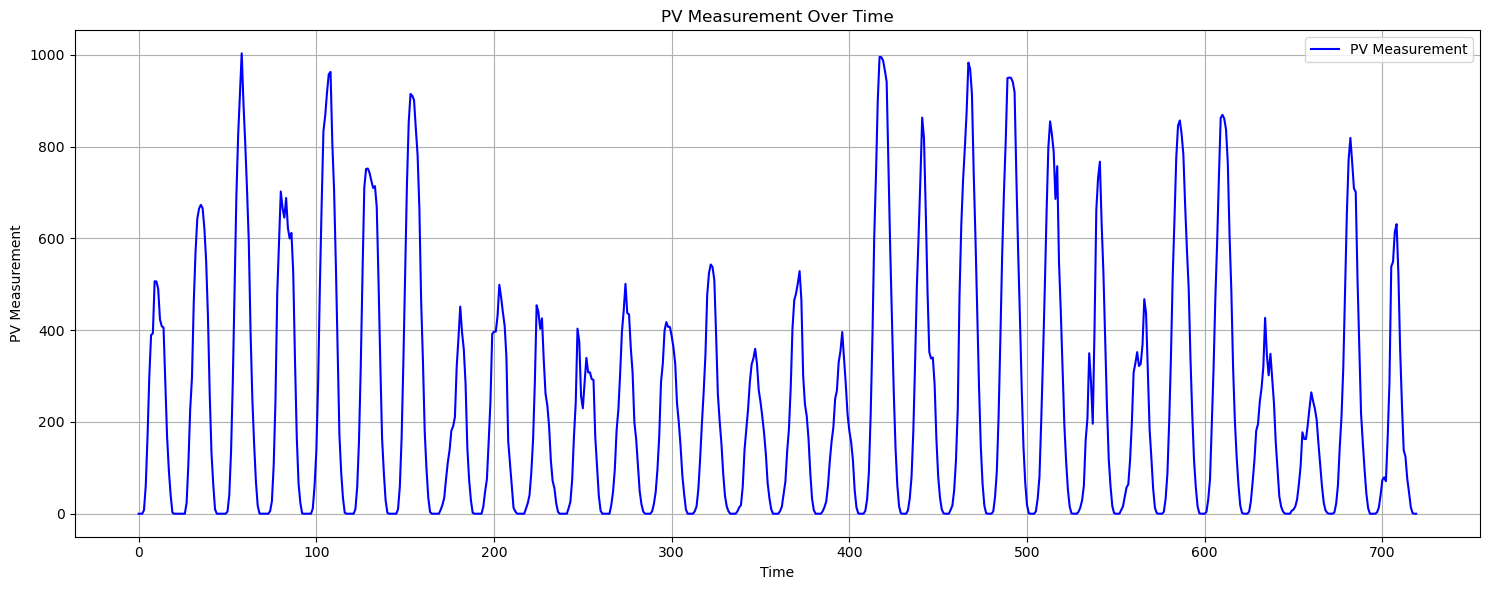

1 --> 105.76986058913741
2 --> 41.7837030647276
3 --> 68.48449139997925
4 --> 44.03814152035701


[I 2023-11-03 23:40:38,252] A new study created in memory with name: no-name-36ae6ddb-b173-46f2-abda-8d2350561f64


5 --> 50.493961980481906
Mean : 62.114031710936636
Std : 23.75500048948792
__________
1 --> 110.8939471465386
2 --> 41.922503354142115
3 --> 68.8027439926159
4 --> 44.124283628965735


[I 2023-11-03 23:40:40,707] Trial 0 finished with value: 63.505167769220876 and parameters: {'n_estimators': 410, 'reg_alpha': 0.018630593514738655, 'reg_lambda': 0.0031232319282800394, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.0660314244127206, 'max_depth': 19, 'num_leaves': 983, 'min_child_samples': 262, 'min_data_per_groups': 9}. Best is trial 0 with value: 63.505167769220876.


5 --> 51.782360723842025
Mean : 63.505167769220876
Std : 25.50535239140937
1 --> 145.89406958063304
2 --> 81.21672416449076
3 --> 112.10584475764932
4 --> 86.87338245726015


[I 2023-11-03 23:40:49,095] Trial 1 finished with value: 102.60245724583596 and parameters: {'n_estimators': 979, 'reg_alpha': 6.757199344555777, 'reg_lambda': 0.1493890918382281, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.0008562045139487013, 'max_depth': 37, 'num_leaves': 59, 'min_child_samples': 107, 'min_data_per_groups': 11}. Best is trial 0 with value: 63.505167769220876.


5 --> 86.92226526914656
Mean : 102.60245724583596
Std : 24.145806535723896
1 --> 115.9252245848366
2 --> 40.23039985403945
3 --> 67.11101124219796
4 --> 43.09628861519409


[I 2023-11-03 23:40:53,710] Trial 2 finished with value: 63.56689104174004 and parameters: {'n_estimators': 761, 'reg_alpha': 0.008191161432683154, 'reg_lambda': 0.5416479818038972, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.012694260183781201, 'max_depth': 19, 'num_leaves': 674, 'min_child_samples': 292, 'min_data_per_groups': 56}. Best is trial 0 with value: 63.505167769220876.


5 --> 51.471530912432115
Mean : 63.56689104174004
Std : 27.79888846958609
1 --> 108.84594336965259
2 --> 41.94740184083159
3 --> 71.86562279447361
4 --> 44.254615049530614


[I 2023-11-03 23:41:13,928] Trial 3 finished with value: 63.7052178192969 and parameters: {'n_estimators': 821, 'reg_alpha': 0.06802749316358567, 'reg_lambda': 0.040073134839575766, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.05998060509181463, 'max_depth': 23, 'num_leaves': 579, 'min_child_samples': 34, 'min_data_per_groups': 92}. Best is trial 0 with value: 63.505167769220876.


5 --> 51.61250604199611
Mean : 63.7052178192969
Std : 24.908791600398015
1 --> 101.64716812989342
2 --> 40.638694932788056
3 --> 67.89863136691619
4 --> 42.59220503793874


[I 2023-11-03 23:41:22,678] Trial 4 finished with value: 60.719995387007444 and parameters: {'n_estimators': 857, 'reg_alpha': 1.1225505744090147, 'reg_lambda': 0.0021941073449364317, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.01984966605302855, 'max_depth': 41, 'num_leaves': 770, 'min_child_samples': 119, 'min_data_per_groups': 86}. Best is trial 4 with value: 60.719995387007444.


5 --> 50.8232774675008
Mean : 60.719995387007444
Std : 22.61144276559447
1 --> 217.94064887619325
2 --> 148.12051901820558
3 --> 198.57870057439945
4 --> 156.20964689414475


[I 2023-11-03 23:41:28,388] Trial 5 finished with value: 174.6863711607187 and parameters: {'n_estimators': 208, 'reg_alpha': 1.2831554575301507, 'reg_lambda': 0.07518745967256402, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.00013801569744453836, 'max_depth': 33, 'num_leaves': 129, 'min_child_samples': 9, 'min_data_per_groups': 89}. Best is trial 4 with value: 60.719995387007444.


5 --> 152.58234044065028
Mean : 174.6863711607187
Std : 28.20460231683415
1 --> 99.59680839190348
2 --> 40.521585335963714
3 --> 68.15108556668525
4 --> 42.63270144843201


[I 2023-11-03 23:41:30,251] Trial 6 finished with value: 60.65012388206627 and parameters: {'n_estimators': 231, 'reg_alpha': 0.005279660257527678, 'reg_lambda': 0.784231623765906, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.039636960841325626, 'max_depth': 6, 'num_leaves': 266, 'min_child_samples': 83, 'min_data_per_groups': 40}. Best is trial 6 with value: 60.65012388206627.


5 --> 52.348438667346905
Mean : 60.65012388206627
Std : 21.77986323676606
1 --> 102.35588181050991
2 --> 39.67807215802521
3 --> 66.61619979684312
4 --> 42.56992928900694


[I 2023-11-03 23:41:33,962] Trial 7 finished with value: 60.19196490310495 and parameters: {'n_estimators': 128, 'reg_alpha': 0.002014590153967212, 'reg_lambda': 0.0706237760655963, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.045086720267259905, 'max_depth': 34, 'num_leaves': 181, 'min_child_samples': 27, 'min_data_per_groups': 43}. Best is trial 7 with value: 60.19196490310495.


5 --> 49.73974146113955
Mean : 60.19196490310495
Std : 23.063701318593328
1 --> 212.39205004072386
2 --> 139.55655297774635
3 --> 187.94913639683026
4 --> 147.69091851079824


[I 2023-11-03 23:41:35,365] Trial 8 finished with value: 166.3316634582648 and parameters: {'n_estimators': 250, 'reg_alpha': 0.0013032758256629675, 'reg_lambda': 1.876893806256648, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.00039460043233988264, 'max_depth': 16, 'num_leaves': 558, 'min_child_samples': 300, 'min_data_per_groups': 38}. Best is trial 7 with value: 60.19196490310495.


5 --> 144.06965936522536
Mean : 166.3316634582648
Std : 28.80574626026605
1 --> 105.01664267462205
2 --> 40.311087080106425
3 --> 67.54119104432681
4 --> 42.26838890188264


[I 2023-11-03 23:41:40,676] Trial 9 finished with value: 61.2276296047249 and parameters: {'n_estimators': 420, 'reg_alpha': 0.2734184906375263, 'reg_lambda': 0.19698387318761618, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.020058894091877902, 'max_depth': 39, 'num_leaves': 630, 'min_child_samples': 150, 'min_data_per_groups': 68}. Best is trial 7 with value: 60.19196490310495.


5 --> 51.000838322686604
Mean : 61.2276296047249
Std : 23.911840342500234
1 --> 195.7983952858946
2 --> 123.81812828672663
3 --> 167.62449249493952
4 --> 131.37817755936243


[I 2023-11-03 23:41:41,281] Trial 10 finished with value: 149.53233272970962 and parameters: {'n_estimators': 53, 'reg_alpha': 0.0013781313949148652, 'reg_lambda': 3.4793746531878167, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.004627620425811624, 'max_depth': 49, 'num_leaves': 327, 'min_child_samples': 195, 'min_data_per_groups': 29}. Best is trial 7 with value: 60.19196490310495.


5 --> 129.04247002162504
Mean : 149.53233272970962
Std : 27.851401843728265
1 --> 112.13285864621423
2 --> 50.676053289050344


[I 2023-11-03 23:41:41,662] Trial 11 finished with value: 72.70819420853208 and parameters: {'n_estimators': 43, 'reg_alpha': 0.006149734527797381, 'reg_lambda': 6.309071358054903, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.050771052013782535, 'max_depth': 2, 'num_leaves': 312, 'min_child_samples': 64, 'min_data_per_groups': 39}. Best is trial 7 with value: 60.19196490310495.


3 --> 79.2785471096575
4 --> 57.6410451336181
5 --> 63.81246686412021
Mean : 72.70819420853208
Std : 21.858828344615667
1 --> 100.11667650588548
2 --> 40.892994618268425
3 --> 69.2284250001484
4 --> 44.49692403676383


[I 2023-11-03 23:41:42,470] Trial 12 finished with value: 60.83472340581254 and parameters: {'n_estimators': 212, 'reg_alpha': 0.0010687268038877431, 'reg_lambda': 0.6906560589103283, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.0909214269444463, 'max_depth': 2, 'num_leaves': 289, 'min_child_samples': 68, 'min_data_per_groups': 60}. Best is trial 7 with value: 60.19196490310495.


5 --> 49.43859686799661
Mean : 60.83472340581254
Std : 21.94535942351482
1 --> 106.53493987761486
2 --> 42.73446270377863
3 --> 67.6419754654479
4 --> 46.40127836639672


[I 2023-11-03 23:42:15,218] Trial 13 finished with value: 62.912973873638386 and parameters: {'n_estimators': 548, 'reg_alpha': 0.005200406151968319, 'reg_lambda': 0.020393854927533407, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.006307189877421744, 'max_depth': 10, 'num_leaves': 187, 'min_child_samples': 1, 'min_data_per_groups': 25}. Best is trial 7 with value: 60.19196490310495.


5 --> 51.25221295495387
Mean : 62.912973873638386
Std : 23.413761427272448
1 --> 152.28295587467986
2 --> 89.61314485388732
3 --> 123.52640061190341
4 --> 95.33492423643347


[I 2023-11-03 23:42:18,608] Trial 14 finished with value: 111.18512478867228 and parameters: {'n_estimators': 322, 'reg_alpha': 0.03148975174363259, 'reg_lambda': 9.505786128463845, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.002173733778672694, 'max_depth': 27, 'num_leaves': 425, 'min_child_samples': 65, 'min_data_per_groups': 44}. Best is trial 7 with value: 60.19196490310495.


5 --> 95.16819836645728
Mean : 111.18512478867228
Std : 23.72534474685957
1 --> 108.0935618453201
2 --> 40.80514271857413
3 --> 67.38413925816009
4 --> 43.46732020491887


[I 2023-11-03 23:42:21,207] Trial 15 finished with value: 62.12033621066398 and parameters: {'n_estimators': 555, 'reg_alpha': 0.003928191679508144, 'reg_lambda': 0.8441456354625482, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.02634154315544335, 'max_depth': 31, 'num_leaves': 50, 'min_child_samples': 194, 'min_data_per_groups': 73}. Best is trial 7 with value: 60.19196490310495.


5 --> 50.851517026346734
Mean : 62.12033621066398
Std : 24.78105673010124
1 --> 126.55116042768888
2 --> 62.45507185161768
3 --> 88.64990843185701
4 --> 68.08320571212715


[I 2023-11-03 23:42:22,658] Trial 16 finished with value: 82.90841068599312 and parameters: {'n_estimators': 133, 'reg_alpha': 0.02077543882553019, 'reg_lambda': 0.015074949766375403, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.00993993857415056, 'max_depth': 11, 'num_leaves': 431, 'min_child_samples': 98, 'min_data_per_groups': 23}. Best is trial 7 with value: 60.19196490310495.


5 --> 68.8027070066749
Mean : 82.90841068599312
Std : 23.557381219743796
1 --> 106.59460013628947
2 --> 41.50061765883682
3 --> 70.1315026802958
4 --> 43.40263308725895


[I 2023-11-03 23:42:33,986] Trial 17 finished with value: 62.56467029895835 and parameters: {'n_estimators': 654, 'reg_alpha': 0.0028869975398631525, 'reg_lambda': 0.28714983421817125, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.03476504437128477, 'max_depth': 47, 'num_leaves': 202, 'min_child_samples': 50, 'min_data_per_groups': 51}. Best is trial 7 with value: 60.19196490310495.


5 --> 51.19399793211066
Mean : 62.56467029895835
Std : 24.232465196797932
1 --> 103.407509024665
2 --> 40.52050205632409
3 --> 67.59455968500434
4 --> 42.10032225978868


[I 2023-11-03 23:42:36,102] Trial 18 finished with value: 60.835392079850465 and parameters: {'n_estimators': 344, 'reg_alpha': 0.013976101386031595, 'reg_lambda': 0.08434812104125282, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.03304463643983052, 'max_depth': 8, 'num_leaves': 248, 'min_child_samples': 145, 'min_data_per_groups': 1}. Best is trial 7 with value: 60.19196490310495.


5 --> 50.554067373470176
Mean : 60.835392079850465
Std : 23.35583320468835
1 --> 121.06615440434135
2 --> 65.02460849329539
3 --> 90.87874566943836
4 --> 69.44045571963969


[I 2023-11-03 23:42:38,152] Trial 19 finished with value: 83.29450587632991 and parameters: {'n_estimators': 132, 'reg_alpha': 0.002532892322511101, 'reg_lambda': 1.4704130977573027, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.009654001535329412, 'max_depth': 27, 'num_leaves': 419, 'min_child_samples': 27, 'min_data_per_groups': 75}. Best is trial 7 with value: 60.19196490310495.


5 --> 70.06256509493478
Mean : 83.29450587632991
Std : 20.904670476886476
1 --> 148.29075418491627
2 --> 73.99256096840823
3 --> 106.85223928544454
4 --> 82.29063629400534


[I 2023-11-03 23:42:38,391] Trial 20 finished with value: 99.24986582236792 and parameters: {'n_estimators': 10, 'reg_alpha': 0.05120031814479527, 'reg_lambda': 0.335829563317974, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.09911665562962974, 'max_depth': 33, 'num_leaves': 6, 'min_child_samples': 188, 'min_data_per_groups': 61}. Best is trial 7 with value: 60.19196490310495.


5 --> 84.82313837906518
Mean : 99.24986582236792
Std : 26.81970243334145
1 --> 99.69946472544964
2 --> 41.2679424150467
3 --> 68.4606139233096
4 --> 42.38334169747283


[I 2023-11-03 23:42:48,741] Trial 21 finished with value: 60.434962349802014 and parameters: {'n_estimators': 991, 'reg_alpha': 0.2375041621319191, 'reg_lambda': 0.0014728730049815087, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.019629864932275337, 'max_depth': 43, 'num_leaves': 783, 'min_child_samples': 98, 'min_data_per_groups': 84}. Best is trial 7 with value: 60.19196490310495.


5 --> 50.363448987731296
Mean : 60.434962349802014
Std : 21.91247714314316
1 --> 101.15511344788668
2 --> 42.473659786617745
3 --> 69.70142002690811
4 --> 43.44249833718762


[I 2023-11-03 23:42:55,953] Trial 22 finished with value: 61.791888123992614 and parameters: {'n_estimators': 671, 'reg_alpha': 0.14233051965831414, 'reg_lambda': 0.0012309005259408202, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.045370268807686485, 'max_depth': 45, 'num_leaves': 957, 'min_child_samples': 89, 'min_data_per_groups': 35}. Best is trial 7 with value: 60.19196490310495.


5 --> 52.18674902136289
Mean : 61.791888123992614
Std : 21.97351565702137
1 --> 101.9393582032303
2 --> 40.58168705698886
3 --> 67.72766343851086
4 --> 42.46196589201092


[I 2023-11-03 23:43:05,108] Trial 23 finished with value: 60.7610649504982 and parameters: {'n_estimators': 934, 'reg_alpha': 0.010352426978551222, 'reg_lambda': 0.004720600276366349, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.016650447989503936, 'max_depth': 44, 'num_leaves': 819, 'min_child_samples': 124, 'min_data_per_groups': 47}. Best is trial 7 with value: 60.19196490310495.


5 --> 51.094650161750074
Mean : 60.7610649504982
Std : 22.7142652229417
1 --> 99.2976934887216
2 --> 41.091756021574724
3 --> 68.17066267138974
4 --> 42.87714484455169


[I 2023-11-03 23:43:12,702] Trial 24 finished with value: 60.81050638581023 and parameters: {'n_estimators': 459, 'reg_alpha': 0.04289213153153863, 'reg_lambda': 0.007661151101096014, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.030887713649280973, 'max_depth': 37, 'num_leaves': 771, 'min_child_samples': 86, 'min_data_per_groups': 83}. Best is trial 7 with value: 60.19196490310495.


5 --> 52.615274902813425
Mean : 60.81050638581023
Std : 21.508286137203466
1 --> 108.22318791608087
2 --> 47.84775164162059
3 --> 70.95089076777954
4 --> 52.02533913924253


[I 2023-11-03 23:43:14,934] Trial 25 finished with value: 66.71813345311469 and parameters: {'n_estimators': 146, 'reg_alpha': 0.0025009450892064175, 'reg_lambda': 0.0094478104307242, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.01462486421407862, 'max_depth': 41, 'num_leaves': 124, 'min_child_samples': 48, 'min_data_per_groups': 97}. Best is trial 7 with value: 60.19196490310495.


5 --> 54.54349780084994
Mean : 66.71813345311469
Std : 22.18457593998747
1 --> 102.35881097473238
2 --> 40.99158397500085
3 --> 67.81721612101953
4 --> 42.94837067940849


[I 2023-11-03 23:43:17,937] Trial 26 finished with value: 61.080123552763645 and parameters: {'n_estimators': 312, 'reg_alpha': 0.010658242532440017, 'reg_lambda': 0.001015479907008874, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.0496961620283221, 'max_depth': 30, 'num_leaves': 880, 'min_child_samples': 132, 'min_data_per_groups': 53}. Best is trial 7 with value: 60.19196490310495.


5 --> 51.28463601365696
Mean : 61.080123552763645
Std : 22.704977041655024
1 --> 109.01453937977217
2 --> 40.47184016461418
3 --> 69.09327066368776
4 --> 43.73398830569375


[I 2023-11-03 23:43:40,414] Trial 27 finished with value: 62.55379316749272 and parameters: {'n_estimators': 627, 'reg_alpha': 0.13964807909954424, 'reg_lambda': 0.042168913263617235, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.0313606290411533, 'max_depth': 50, 'num_leaves': 367, 'min_child_samples': 24, 'min_data_per_groups': 66}. Best is trial 7 with value: 60.19196490310495.


5 --> 50.45532732369579
Mean : 62.55379316749272
Std : 25.256825943717196
1 --> 106.61537755236876
2 --> 40.97117711825823
3 --> 67.74483603637842
4 --> 43.2600267110981


[I 2023-11-03 23:43:44,619] Trial 28 finished with value: 61.8818493713571 and parameters: {'n_estimators': 742, 'reg_alpha': 0.022032660818489692, 'reg_lambda': 0.15558099643320575, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.021933995082929685, 'max_depth': 24, 'num_leaves': 487, 'min_child_samples': 177, 'min_data_per_groups': 19}. Best is trial 7 with value: 60.19196490310495.


5 --> 50.817829438681976
Mean : 61.8818493713571
Std : 24.25656276760114
1 --> 110.01159338070514
2 --> 42.00366013083184
3 --> 69.23284185779471
4 --> 44.34619727860603


[I 2023-11-03 23:43:46,552] Trial 29 finished with value: 63.639087745768265 and parameters: {'n_estimators': 354, 'reg_alpha': 0.006342048204121072, 'reg_lambda': 0.004956727909051532, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.07176534606048594, 'max_depth': 19, 'num_leaves': 982, 'min_child_samples': 239, 'min_data_per_groups': 32}. Best is trial 7 with value: 60.19196490310495.


5 --> 52.60114608090364
Mean : 63.639087745768265
Std : 25.075258207181406
1 --> 98.7322686129915
2 --> 41.31902781765038
3 --> 69.98538730206259
4 --> 43.03908117635993


[I 2023-11-03 23:43:50,441] Trial 30 finished with value: 61.40003583780996 and parameters: {'n_estimators': 260, 'reg_alpha': 0.0018722153798120323, 'reg_lambda': 0.0027857192141600086, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.07405764368455615, 'max_depth': 36, 'num_leaves': 677, 'min_child_samples': 80, 'min_data_per_groups': 45}. Best is trial 7 with value: 60.19196490310495.


5 --> 53.92441427998536
Mean : 61.40003583780996
Std : 21.27750135991739
1 --> 102.28763017704142
2 --> 40.91267129419881
3 --> 67.80183680768239
4 --> 42.520411077254344


[I 2023-11-03 23:43:58,247] Trial 31 finished with value: 60.85697087238244 and parameters: {'n_estimators': 885, 'reg_alpha': 0.4808472217975215, 'reg_lambda': 0.0021843256188959765, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.01786278337635426, 'max_depth': 42, 'num_leaves': 786, 'min_child_samples': 125, 'min_data_per_groups': 82}. Best is trial 7 with value: 60.19196490310495.


5 --> 50.7623050057352
Mean : 60.85697087238244
Std : 22.80630387862931
1 --> 101.83116663111836
2 --> 42.62326359811993
3 --> 69.66535075081431
4 --> 44.20401214844741


[I 2023-11-03 23:44:07,873] Trial 32 finished with value: 62.005738007752974 and parameters: {'n_estimators': 999, 'reg_alpha': 0.9770071987140629, 'reg_lambda': 0.0018687079525294694, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.043870259250176034, 'max_depth': 40, 'num_leaves': 717, 'min_child_samples': 113, 'min_data_per_groups': 99}. Best is trial 7 with value: 60.19196490310495.


5 --> 51.704896910264814
Mean : 62.005738007752974
Std : 22.10621413781242
1 --> 106.66339026794707
2 --> 40.38897636558785
3 --> 67.34151378858319
4 --> 43.019466724451355


[I 2023-11-03 23:44:13,468] Trial 33 finished with value: 61.57621688787312 and parameters: {'n_estimators': 871, 'reg_alpha': 3.3834715832014393, 'reg_lambda': 0.003544014356107552, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.011216887717287063, 'max_depth': 36, 'num_leaves': 881, 'min_child_samples': 174, 'min_data_per_groups': 80}. Best is trial 7 with value: 60.19196490310495.


5 --> 50.467737292796116
Mean : 61.57621688787312
Std : 24.424341580682366
1 --> 102.55703510859317
2 --> 41.80680771871381
3 --> 69.27167496744894
4 --> 43.34217537208


[I 2023-11-03 23:44:27,552] Trial 34 finished with value: 61.81006099017346 and parameters: {'n_estimators': 950, 'reg_alpha': 0.08609305923859557, 'reg_lambda': 0.001367244607802167, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.023227293544307026, 'max_depth': 43, 'num_leaves': 550, 'min_child_samples': 106, 'min_data_per_groups': 91}. Best is trial 7 with value: 60.19196490310495.


5 --> 52.07261178403139
Mean : 61.81006099017346
Std : 22.59204479740769
1 --> 111.2109901938596
2 --> 41.83470590038549
3 --> 71.69327104297962
4 --> 44.85645136961374


[I 2023-11-03 23:44:39,687] Trial 35 finished with value: 64.32083958683566 and parameters: {'n_estimators': 756, 'reg_alpha': 0.0038975489855879704, 'reg_lambda': 0.002762734863589066, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.06430316362898224, 'max_depth': 34, 'num_leaves': 144, 'min_child_samples': 45, 'min_data_per_groups': 17}. Best is trial 7 with value: 60.19196490310495.


5 --> 52.00877942733982
Mean : 64.32083958683566
Std : 25.64805806189471
1 --> 99.35144407554044
2 --> 39.426987823107645
3 --> 66.20602578172917
4 --> 41.954925444825726


[I 2023-11-03 23:44:48,366] Trial 36 finished with value: 59.64187638849696 and parameters: {'n_estimators': 810, 'reg_alpha': 0.35736251355940796, 'reg_lambda': 0.04022374431736895, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.006731113162474734, 'max_depth': 16, 'num_leaves': 890, 'min_child_samples': 76, 'min_data_per_groups': 59}. Best is trial 36 with value: 59.64187638849696.


5 --> 51.269998817281824
Mean : 59.64187638849696
Std : 21.961311939913397
1 --> 101.72505633908048
2 --> 39.640737918189174
3 --> 66.54994162474104
4 --> 43.20168948717434


[I 2023-11-03 23:45:11,304] Trial 37 finished with value: 60.10001255538507 and parameters: {'n_estimators': 806, 'reg_alpha': 0.25224191837877474, 'reg_lambda': 0.04511636268685804, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.007405856677720909, 'max_depth': 16, 'num_leaves': 890, 'min_child_samples': 17, 'min_data_per_groups': 56}. Best is trial 36 with value: 59.64187638849696.


5 --> 49.382637407740276
Mean : 60.10001255538507
Std : 22.773858813330108
1 --> 103.0511834393512
2 --> 39.63161036078938
3 --> 66.61889364954683
4 --> 43.294313805487164


[I 2023-11-03 23:45:35,092] Trial 38 finished with value: 60.4317789367415 and parameters: {'n_estimators': 792, 'reg_alpha': 0.22203294852966673, 'reg_lambda': 0.04750945884138305, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.007424904035404535, 'max_depth': 15, 'num_leaves': 916, 'min_child_samples': 15, 'min_data_per_groups': 58}. Best is trial 36 with value: 59.64187638849696.


5 --> 49.562893428532895
Mean : 60.4317789367415
Std : 23.23431266351562
1 --> 103.86706056841034
2 --> 45.84665418835466
3 --> 69.05171621828312
4 --> 49.74468123048706


[I 2023-11-03 23:46:02,275] Trial 39 finished with value: 64.28493775006417 and parameters: {'n_estimators': 801, 'reg_alpha': 0.07430576822801611, 'reg_lambda': 0.049641407358535505, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.0029594704342845433, 'max_depth': 15, 'num_leaves': 905, 'min_child_samples': 16, 'min_data_per_groups': 57}. Best is trial 36 with value: 59.64187638849696.


5 --> 52.91457654478569
Mean : 64.28493775006417
Std : 21.307937948414107
1 --> 99.25936095739526
2 --> 40.63782683433618
3 --> 65.63103086222172
4 --> 43.79911134572794


[I 2023-11-03 23:46:16,156] Trial 40 finished with value: 59.76638285127101 and parameters: {'n_estimators': 727, 'reg_alpha': 0.4076311191443963, 'reg_lambda': 0.10483419546424344, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.005050333534230803, 'max_depth': 16, 'num_leaves': 835, 'min_child_samples': 33, 'min_data_per_groups': 66}. Best is trial 36 with value: 59.64187638849696.


5 --> 49.50458425667398
Mean : 59.76638285127101
Std : 21.541816733989602
1 --> 98.9093382726148
2 --> 39.786199143636
3 --> 65.80104188342412
4 --> 42.79533533527891


[I 2023-11-03 23:46:29,516] Trial 41 finished with value: 59.349924310434936 and parameters: {'n_estimators': 699, 'reg_alpha': 0.3394266524573342, 'reg_lambda': 0.12191204685854004, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.006853996842924638, 'max_depth': 15, 'num_leaves': 928, 'min_child_samples': 31, 'min_data_per_groups': 65}. Best is trial 41 with value: 59.349924310434936.


5 --> 49.45770691722088
Mean : 59.349924310434936
Std : 21.731147574229244
1 --> 99.01349107452465
2 --> 40.524931470294874
3 --> 65.60811844318236
4 --> 43.80226949358481


[I 2023-11-03 23:46:43,331] Trial 42 finished with value: 59.64837565399589 and parameters: {'n_estimators': 721, 'reg_alpha': 0.47568719809770765, 'reg_lambda': 0.1101901857556747, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.005126008947418241, 'max_depth': 21, 'num_leaves': 818, 'min_child_samples': 37, 'min_data_per_groups': 66}. Best is trial 41 with value: 59.349924310434936.


5 --> 49.293067788392726
Mean : 59.64837565399589
Std : 21.490316168313484
1 --> 101.87574512551951
2 --> 42.12939376481126
3 --> 66.40521138839266
4 --> 45.601955739442815


[I 2023-11-03 23:46:57,096] Trial 43 finished with value: 61.29078392288793 and parameters: {'n_estimators': 704, 'reg_alpha': 0.4558437843820282, 'reg_lambda': 0.08950853138806682, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.00426106406268864, 'max_depth': 20, 'num_leaves': 1000, 'min_child_samples': 37, 'min_data_per_groups': 65}. Best is trial 41 with value: 59.349924310434936.


5 --> 50.441613596273406
Mean : 61.29078392288793
Std : 21.92851633583363
1 --> 105.21919026137883
2 --> 40.98031492451981
3 --> 66.55856612725168
4 --> 44.91458639042511


[I 2023-11-03 23:48:22,363] Trial 44 finished with value: 61.49882774444261 and parameters: {'n_estimators': 614, 'reg_alpha': 0.45962838355383484, 'reg_lambda': 0.12200483618162615, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.006854697424316774, 'max_depth': 22, 'num_leaves': 840, 'min_child_samples': 1, 'min_data_per_groups': 74}. Best is trial 41 with value: 59.349924310434936.


5 --> 49.821481018637655
Mean : 61.49882774444261
Std : 23.534986328014305
1 --> 110.63630346693174
2 --> 51.63453133759948
3 --> 75.39711629172915
4 --> 56.19558501049079


[I 2023-11-03 23:48:32,606] Trial 45 finished with value: 70.35517411496727 and parameters: {'n_estimators': 837, 'reg_alpha': 0.7436562328360591, 'reg_lambda': 0.026680731809388004, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.0022112318580166947, 'max_depth': 17, 'num_leaves': 719, 'min_child_samples': 59, 'min_data_per_groups': 70}. Best is trial 41 with value: 59.349924310434936.


5 --> 57.91233446808519
Mean : 70.35517411496727
Std : 21.69687189834952
1 --> 99.77244185560828
2 --> 40.750844273381574
3 --> 65.60588681992728
4 --> 44.14788816349116


[I 2023-11-03 23:48:44,767] Trial 46 finished with value: 59.986630479462896 and parameters: {'n_estimators': 719, 'reg_alpha': 1.4977802988273945, 'reg_lambda': 0.13504755528285495, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.004849403025032364, 'max_depth': 13, 'num_leaves': 938, 'min_child_samples': 37, 'min_data_per_groups': 62}. Best is trial 41 with value: 59.349924310434936.


5 --> 49.65609128490618
Mean : 59.986630479462896
Std : 21.64295773616057
1 --> 100.41642155797231
2 --> 40.744874270956466
3 --> 66.36767355413616
4 --> 43.80723041426405


[I 2023-11-03 23:49:01,487] Trial 47 finished with value: 60.21754083698462 and parameters: {'n_estimators': 707, 'reg_alpha': 1.5416927035831012, 'reg_lambda': 0.1358681213505572, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.004982555457691542, 'max_depth': 13, 'num_leaves': 936, 'min_child_samples': 37, 'min_data_per_groups': 62}. Best is trial 41 with value: 59.349924310434936.


5 --> 49.75150438759413
Mean : 60.21754083698462
Std : 21.962673307138665
1 --> 111.66411550327916
2 --> 51.34292830854325
3 --> 75.06685795410866
4 --> 55.822413206787296


[I 2023-11-03 23:49:09,437] Trial 48 finished with value: 70.30011190258472 and parameters: {'n_estimators': 579, 'reg_alpha': 0.7003179486909529, 'reg_lambda': 0.07483598963639716, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.0032389324540173414, 'max_depth': 12, 'num_leaves': 844, 'min_child_samples': 70, 'min_data_per_groups': 70}. Best is trial 41 with value: 59.349924310434936.


5 --> 57.60424454020524
Mean : 70.30011190258472
Std : 22.198496702369752
1 --> 100.79011031931735
2 --> 40.0050553280133
3 --> 68.79956419073895
4 --> 42.73695637382164


[I 2023-11-03 23:49:14,186] Trial 49 finished with value: 60.6160752853592 and parameters: {'n_estimators': 714, 'reg_alpha': 1.893692784439907, 'reg_lambda': 0.2332722833725539, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.012508551280335532, 'max_depth': 5, 'num_leaves': 736, 'min_child_samples': 50, 'min_data_per_groups': 79}. Best is trial 41 with value: 59.349924310434936.


5 --> 50.74869021490482
Mean : 60.6160752853592
Std : 22.4622568164368
__________
__________
__________


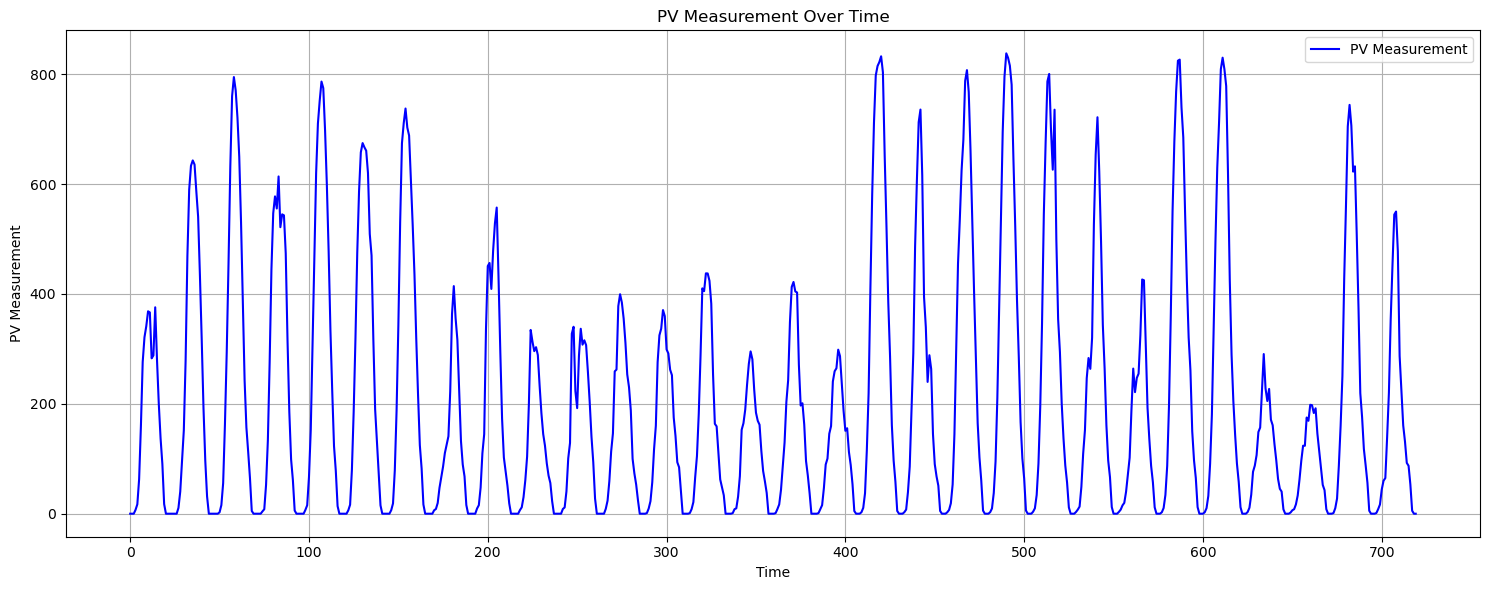

In [153]:
for loc in locations:
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    train_data, test_data, is_day= preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    train_data = feature_engineering(train_data)
    test_data = feature_engineering(test_data)
    train_data = regexdf(train_data)
    test_data = regexdf(test_data)

    evaluate_model(train_data,lgb.LGBMRegressor(verbose=-1))
    print('__________')
    param = tune_model(train_data)
    param.setdefault('verbose', -1)
    print('__________')
    #model = bagging_model(train_data,lgb.LGBMRegressor(**param))
    print('__________')
    prediction = final_model(train_data, lgb.LGBMRegressor(**param), param,test_data)
    print('__________')
    final_prediction = post_process(prediction, is_day)
    plot_targets(final_prediction)
    all_predictions.append([final_prediction])
submission(all_predictions)

In [152]:
all_predictions

[[0        0.000000
  1        0.000000
  2        0.000000
  3       50.357006
  4      372.701058
            ...    
  715    247.741065
  716     80.039508
  717      1.430945
  718      0.000000
  719      0.000000
  Name: is_day:idx, Length: 720, dtype: float64]]